In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score


In [2]:
head = "/home/dhoogla/PhD/clean-ids-collection"
ctu_data = {    
    'ctu13-10': f'{head}/ctu-13/dirty-with-metadata/10/capture20110818.binetflow.parquet',
    'ctu13-11': f'{head}/ctu-13/dirty-with-metadata/11/capture20110818-2.binetflow.parquet',
    'ctu13-12': f'{head}/ctu-13/dirty-with-metadata/12/capture20110819.binetflow.parquet',
    'ctu13-13': f'{head}/ctu-13/dirty-with-metadata/13/capture20110815-3.binetflow.parquet',
    'ctu13-1': f'{head}/ctu-13/dirty-with-metadata/1/capture20110810.binetflow.parquet',
    'ctu13-2': f'{head}/ctu-13/dirty-with-metadata/2/capture20110811.binetflow.parquet',
    'ctu13-3': f'{head}/ctu-13/dirty-with-metadata/3/capture20110812.binetflow.parquet',
    'ctu13-4': f'{head}/ctu-13/dirty-with-metadata/4/capture20110815.binetflow.parquet',
    'ctu13-5': f'{head}/ctu-13/dirty-with-metadata/5/capture20110815-2.binetflow.parquet',
    'ctu13-6': f'{head}/ctu-13/dirty-with-metadata/6/capture20110816.binetflow.parquet',
    'ctu13-7': f'{head}/ctu-13/dirty-with-metadata/7/capture20110816-2.binetflow.parquet',
    'ctu13-8': f'{head}/ctu-13/dirty-with-metadata/8/capture20110816-3.binetflow.parquet',
    'ctu13-9': f'{head}/ctu-13/dirty-with-metadata/9/capture20110817.binetflow.parquet',
    'ctu13': f'{head}/ctu-13/dirty-with-metadata/all/ctu-13.binetflow.parquet'   
}


In [3]:
dataset = "ctu13-1"
datapaths = [f"{ctu_data[dataset]}"]


In [4]:
df = pd.concat(objs=[pd.read_parquet(path) for path in datapaths], ignore_index=True, copy=False, sort=False, verify_integrity=False)

In [5]:
df.columns

Index(['dur', 'proto_icmp', 'proto_rtcp', 'proto_rtp', 'proto_tcp',
       'proto_udp', 'proto_udt', 'srcaddr', 'sport', 'dir_->', 'dir_<-',
       'dir_<->', 'dir_<?', 'dir_<?>', 'dir_?>', 'dstaddr', 'dport', 'state',
       'stos', 'dtos', 'tot_pkts', 'tot_bytes', 'src_bytes', 'label'],
      dtype='object')

In [6]:
df = df[['dport', 'label']]
df['label'] = df['label'].astype(dtype='object')
df['label'].value_counts()

flow=Background-UDP-Established                                            1169572
flow=To-Background-UDP-CVUT-DNS-Server                                      924498
flow=Background-TCP-Established                                             216352
flow=Background-Established-cmpgw-CVUT                                      137167
flow=Background-TCP-Attempt                                                  52794
                                                                            ...   
flow=From-Botnet-V42-TCP-Established-HTTP-Ad-60                                  1
flow=From-Botnet-V42-TCP-HTTP-Not-Encrypted-Down-2                               1
flow=From-Botnet-V42-TCP-Established-HTTP-Binary-Download-Custom-Port-5          1
flow=From-Botnet-V42-TCP-Established-HTTP-Adobe-4                                1
flow=From-Botnet-V42-TCP-Established-HTTP-Ad-49                                  1
Name: label, Length: 108, dtype: int64

In [7]:
df['label'] = df['label'].str.startswith('flow=From-Botnet', na=False)
df['label'] = df['label'].astype(dtype='float32', copy=False)
df['label'].value_counts()

0.0    2573344
1.0      27583
Name: label, dtype: int64

In [8]:
col = df.columns[-1]
cols = df.columns[:-1]
vc = df[col].value_counts()
n = vc.iloc[-1]
m = vc.iloc[0]
initial_cut = df.loc[df[col] == vc.index[0]].sample(n=int(m-n), replace=False)
df = df.drop(index=initial_cut.index)

In [9]:
print(df.shape)
df['label'].value_counts()

(55166, 2)


0.0    27583
1.0    27583
Name: label, dtype: int64

In [10]:
gp = df.groupby('label')
with pd.option_context('display.max_rows', 50):
    print(gp.get_group(0.0)['dport'].value_counts())
    print(gp.get_group(1.0)['dport'].value_counts())

13363    10807
53       10079
80        2782
443        780
6881       130
         ...  
41646        1
9475         1
43842        1
2147         1
34060        1
Name: dport, Length: 2381, dtype: int64
53       25597
80        1199
65500      320
6667       227
443         95
587         62
3817        13
4190        13
888         10
5296         9
9541         6
5231         5
8399         5
65520        5
6251         5
41422        2
10298        2
81           2
82           2
2012         2
9381         1
88           1
Name: dport, dtype: int64


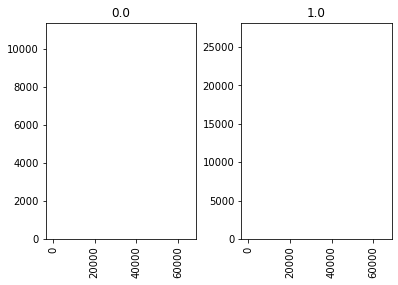

In [11]:
hist = df.hist(column='dport', by='label', bins=128, log=True, sharex=True, sharey=True)

In [12]:
model = RF()
best_param_dict = {
        'bootstrap': True,
        'max_depth': 16,
        'max_features': 'sqrt',
        'min_impurity_decrease': 0.0,
        'min_samples_leaf': 2,
        'n_estimators': 10,
        'max_samples': 0.5,
        'criterion': 'entropy',
        'n_jobs': -1,
        }
model.set_params(**best_param_dict)

RandomForestClassifier(criterion='entropy', max_depth=16, max_features='sqrt',
                       max_samples=0.5, min_samples_leaf=2, n_estimators=10,
                       n_jobs=-1)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(df['dport'], df['label'], test_size=0.8, random_state=42)

In [14]:
model.fit(X=X_train.array.reshape(-1,1), y=y_train.array)

RandomForestClassifier(criterion='entropy', max_depth=16, max_features='sqrt',
                       max_samples=0.5, min_samples_leaf=2, n_estimators=10,
                       n_jobs=-1)

In [15]:
intra_outputs = model.predict(X=X_test.array.reshape(-1,1))
intra_acc = accuracy_score(y_true=y_test, y_pred=intra_outputs)
intra_rec = recall_score(y_true=y_test, y_pred=intra_outputs)
intra_pre = precision_score(y_true=y_test, y_pred=intra_outputs)
print(f"{dataset} => Destination Port")
print(f"Accuracy: {intra_acc:.3f}")
print(f"Recall: {intra_rec:.3f}")
print(f"Precision: {intra_pre:.3f}")


ctu13-1 => Destination Port
Accuracy: 0.793
Recall: 0.952
Precision: 0.722
